In [1]:
import os
from collections import namedtuple

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from jax.experimental.ode import build_odeint, odeint
import jax.numpy as np
from jax.random import PRNGKey
import numpy as onp

import numpyro
import numpyro.distributions as dist
# from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

NUM_CHAINS = 1
numpyro.set_host_device_count(NUM_CHAINS)
numpyro.enable_x64()

# Data

In [2]:
NB_DAYS_BEFORE_TEN_DEATHS = 30

ix = pd.IndexSlice

full = pd.read_csv('full.csv', index_col=['location', 'date', 'variable'], parse_dates=['date']).iloc[:, 0]
populations_country = pd.read_csv('populations_country.csv', index_col='location').iloc[:, 0]

country = 'France'
subset = full.loc[country]
deaths_subset = subset.loc[ix[:, 'total_deaths']]

pop_country = populations_country.loc[country]

ten_deaths_date = deaths_subset.gt(10).cumsum().loc[lambda s: s==1].index[0]
begin_date = ten_deaths_date - pd.Timedelta(NB_DAYS_BEFORE_TEN_DEATHS, unit='days')

total_deaths = deaths_subset.loc[begin_date:].values
# data = total_deaths / pop_country

times = deaths_subset.loc[begin_date:].index.map(onp.datetime64).to_numpy()

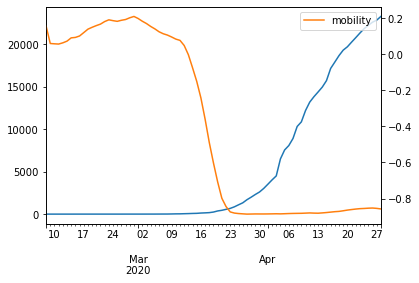

In [3]:
mobility = subset.loc[ix[:, 'transit']].rename('mobility')
mobility = (mobility
            .reindex(deaths_subset.loc[begin_date:].index)
            .fillna(method='ffill')
            .fillna(method='bfill')
            #.fillna(mobility.iloc[-1])
            .rolling('7d').mean())

to_plot = pd.DataFrame({'deaths': total_deaths}, index=times).join(mobility)
to_plot['deaths'].plot(label='deaths')
to_plot['mobility'].plot(secondary_y=True)
plt.legend() ;

## France data
This data is rich, because we have the number of hospitalized and critical.

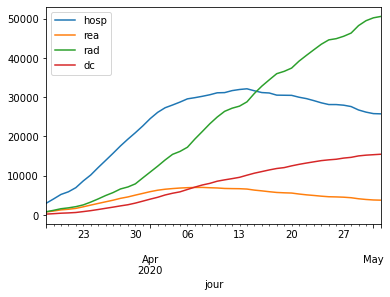

In [4]:
hosp = (pd.read_csv('donnees-hospitalieres-covid19-2020-05-02-19h00.csv', sep=';', parse_dates=['jour'])
        .loc[lambda f: f['sexe'] == 0]
        .groupby('jour')
        .sum()
        .drop('sexe', axis=1))

hosp_indexed = hosp.reindex(times).fillna(0)
hosp.plot() ;

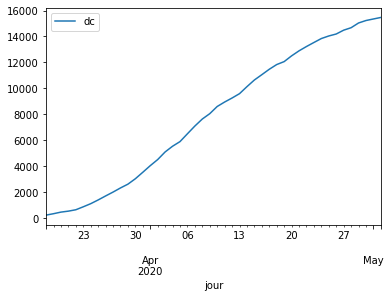

In [5]:
hosp.dc.plot()
plt.legend() ;

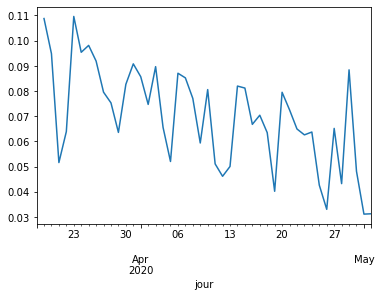

In [6]:
hosp.eval('dc.diff() / rea').plot() ;

# Model

https://www.kaggle.com/anjum48/seir-hcd-model

## Prior choice

We use France's Covid data, that includes the number of critical, deceased, hospitalized (and recovered).

In [7]:
Params = namedtuple('Params', 
                    ['r0', 'r1', 
                     't_inc', 't_inf', 't_hosp', 't_crit', 
                     'm_a', 'c_a', 'f_a']
                   )

PRIOR_MEANS = Params(r0=3.3,
              r1=0.5, 
              t_inc=5.1, 
              t_inf=2.79, 
              t_hosp=5.14, 
              t_crit=5., 
              m_a=0.85, 
              c_a=0.2, 
              f_a=0.33)

BUMP_CRITICAL = abs(hosp_indexed['rea'].diff().min()) + 1
BUMP_HOSP = abs(hosp_indexed['hosp'].diff().min()) + 1

## Implementation

In [8]:
mobility_data = np.asarray(mobility.to_numpy())

def dz_dt(z, t, r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a):
    s = z[0]
    e = z[1]
    i = z[2]
    r = z[3]
    h = z[4]
    c = z[5]

    int_t = np.array([t]).astype(int)[0]
    rt = r0 * (1 + mobility_data[int_t]) - r1 * mobility_data[int_t]
    
    ds = - (rt / t_inf) * i * s
    de = (rt / t_inf) * i * s - (e / t_inc)
    di = e / t_inc - i / t_inf
    dr = m_a * i / t_inf + (1 - c_a) * (h / t_hosp)
    dh = (1 - m_a) * (i / t_inf) + (1 - f_a) * c / t_crit - h / t_hosp
    dc = c_a * h / t_hosp - c / t_crit
    dd = f_a * c / t_crit
    
    return np.stack([ds, de, di, dr, dh, dc, dd])

seirhcd_int = build_odeint(dz_dt, rtol=1e-5, atol=1e-9, mxstep=500)

In [23]:
def reparametrize_beta(mean, sample_size):
#     v = numpyro.sample(f'sample_size_{i}', dist.Gamma(*reparametrize_gamma(10., 5)))
    alpha = mean * sample_size
    beta = (1 - mean) * sample_size
    return alpha, beta 

def reparametrize_gamma(mean, std):
    var = std ** 2
    alpha = mean ** 2 / var
    beta = mean / var
    return alpha, beta

def model(N, y=None, compartments='d'):
#     tau = numpyro.sample('tau', dist.Exponential(0.03))
    i_init = numpyro.sample('i_init', 
                            dist.Gamma(*reparametrize_gamma(50, 25.))
#                             dist.Exponential(1. / tau)
                           )
#     i_init = numpyro.sample('i_init', )
    i_init /= pop_country
    z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
    ts = np.arange(float(N))
    
    kappa0 = numpyro.sample('kappa0', dist.TruncatedNormal(0, 0., 0.5))
    kappa1 = numpyro.sample('kappa1', dist.TruncatedNormal(0, 0, 0.5))
    r0 = numpyro.sample('r0', dist.TruncatedNormal(0, PRIOR_MEANS.r0, kappa0))
    r1 = numpyro.sample('r1', dist.TruncatedNormal(0, PRIOR_MEANS.r1, kappa1))
    
#     t_delta = numpyro.sample('t_delta', dist.Gamma(*reparametrize_gamma(3., 1.)))
#     t_delta = int(np.floor(t_delta))
    
    t_inc = numpyro.sample('t_inc', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_inc, .86)))
    t_inf = numpyro.sample('t_inf', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_inf, 3.)))
    t_hosp = numpyro.sample('t_hosp', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_hosp, 3.)))
    t_crit = numpyro.sample('t_crit', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_crit, 3.)))
    
#     sample_size_m = numpyro.sample('sample_size_m', dist.Gamma(*reparametrize_gamma(7., 2)))
#     sample_size_c = numpyro.sample('sample_size_c', dist.Gamma(*reparametrize_gamma(7., 2)))
#     sample_size_f = numpyro.sample('sample_size_f', dist.Gamma(*reparametrize_gamma(7., 2)))
    m_a = numpyro.sample('m_a', dist.Beta(*reparametrize_beta(PRIOR_MEANS.m_a, 5)))
    c_a = numpyro.sample('c_a', dist.Beta(*reparametrize_beta(PRIOR_MEANS.c_a, 5)))
    f_a = numpyro.sample('f_a', dist.Beta(*reparametrize_beta(PRIOR_MEANS.f_a, 5)))
    
    params = (r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)
    
    z = seirhcd_int(z_init, ts, *params)
    
    total_deaths = z[:, -1] * pop_country
    daily_deaths = np.hstack((np.array([0.]), np.diff(z[:, -1] * pop_country)))
    daily_deaths += 1

    daily_critical = np.hstack((np.array([0]), np.diff(z[:, -2] * pop_country))) 
    daily_critical += BUMP_CRITICAL
    
    daily_hosp = np.hstack((np.array([0]), np.diff(z[:, -3] * pop_country))) 
    daily_hosp += BUMP_HOSP

#     critical = z[:, -2] * pop_country + 1
#     hosp = z[:, -3] * pop_country + 1

    psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))
    
    if compartments == 'd':
        numpyro.sample('deceased', dist.GammaPoisson(psi, rate=psi / daily_deaths), obs=y)

    elif compartments == 'hcd':
        psi_h = numpyro.sample('psi_h', dist.TruncatedNormal(scale=5.))
        psi_c = numpyro.sample('psi_c', dist.TruncatedNormal(scale=5.))
        numpyro.sample('y', 
                       dist.GammaPoisson(
                           np.array([psi_h, psi_c, psi]),
                           rate=np.stack([psi_h / daily_hosp, psi_c / daily_critical, psi / daily_deaths]).T),
                       obs=y)
#         true_hosp = y[:, -3] if y is not None else None
#         true_critical = y[:, -2] if y is not None else None
#         true_deceased = y[:, -1] if y is not None else None
    
#         numpyro.sample('hosp', dist.Poisson(hosp), obs=true_hosp)
#         numpyro.sample('critical', dist.Poisson(critical), obs=true_critical)
#         numpyro.sample('deceased', dist.GammaPoisson(psi, rate=psi / daily_deaths), obs=true_deceased)

In [24]:
daily_deaths_true = np.hstack((np.array([0.]), np.diff(hosp_indexed['dc'].to_numpy())))

In [25]:
# # To use for regular (only deaths) data
# # use dense_mass for better mixing rate
# mcmc = MCMC(NUTS(model, dense_mass=True),
#             200, 200, num_chains=NUM_CHAINS,
#             progress_bar=True)
# mcmc.run(PRNGKey(0), N=daily_deaths_true.shape[0], y=daily_deaths_true + 1, compartments='d')
# mcmc.print_summary()

(81, 3)


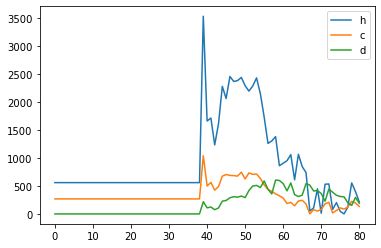

In [26]:
daily_critical = np.hstack((np.array([0.]), np.diff(hosp_indexed['rea'].to_numpy()))) + BUMP_CRITICAL
daily_hosp = np.hstack((np.array([0.]), np.diff(hosp_indexed['hosp'].to_numpy()))) + BUMP_HOSP

data = np.stack([daily_hosp, daily_critical, daily_deaths_true + 1]).T
print(data.shape)

df = pd.DataFrame(data)
df.columns = 'h c d'.split()
df.plot()

In [27]:
# For HCD observations
# use dense_mass for better mixing rate
mcmc = MCMC(NUTS(model, dense_mass=True),
            100, 100, num_chains=NUM_CHAINS,
            progress_bar=True)
mcmc.run(PRNGKey(0), N=data.shape[0], y=data, compartments='hcd')
mcmc.print_summary()

sample: 100%|██████████| 200/200 [04:54<00:00,  1.47s/it, 1023 steps of size 1.93e-05. acc. prob=0.67]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       c_a      0.48      0.00      0.48      0.48      0.48      6.38      1.02
       f_a      0.87      0.00      0.87      0.87      0.87      2.42      3.41
    i_init      0.98      0.00      0.98      0.98      0.98      4.47      1.47
    kappa0      0.82      0.00      0.82      0.81      0.82      2.53      2.61
    kappa1      1.09      0.00      1.09      1.09      1.10      2.47      2.68
       m_a      0.64      0.00      0.64      0.64      0.64      5.17      1.07
       psi      9.51      0.01      9.51      9.50      9.51      2.36      3.90
     psi_c      2.14      0.00      2.14      2.14      2.14      5.57      1.41
     psi_h     13.67      0.00     13.67     13.66     13.67      7.16      1.03
        r0      0.95      0.01      0.95      0.94      0.96      2.51      2.65
        r1      1.24      0.00      1.24      1.23      1.24      2.50      2.64
    t_crit      0.16      0

## Debug

In [32]:
params = PRIOR_MEANS

i_init = 50 / pop_country
z_init = np.array([1 - i_init, 0, i_init, 0, 0, 0, 0])
ts = np.arange(float(data.shape[0]))
z = seirhcd_int(z_init, ts, *params)

total_deaths = z[:, -1] * pop_country
daily_deaths = np.hstack((np.array([0.]), np.diff(z[:, -1] * pop_country)))
daily_deaths += 1

# critical = z[:, -2] * pop_country + 1
# hosp = z[:, -3] * pop_country + 1

daily_critical = np.hstack((np.array([0]), np.diff(z[:, -2] * pop_country))) 
daily_critical += BUMP_CRITICAL

daily_hosp = np.hstack((np.array([0]), np.diff(z[:, -3] * pop_country))) 
daily_hosp += BUMP_HOSP

nb_samples = 100
samples = dict()
for i in range(nb_samples):
    psi = dist.TruncatedNormal(scale=2.18).sample(PRNGKey(5*i))
    psi_h = dist.TruncatedNormal(scale=5.).sample(PRNGKey(5*i+1))
    psi_c = dist.TruncatedNormal(scale=5.).sample(PRNGKey(5*i+2))
    distrib = dist.GammaPoisson(
                       np.array([psi_h, psi_c, psi]),
                       rate=np.stack([psi_h / daily_hosp, psi_c / daily_critical, psi / daily_deaths]).T)

    samples[i] = distrib.sample(PRNGKey(5*i+3), (nb_samples,))

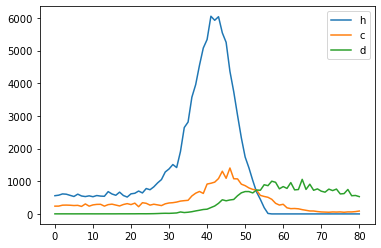

In [33]:
mu = np.mean(samples[0], axis=0)
sigma = np.percentile(samples[0].astype(float), (10., 90.), axis=0)
df = pd.DataFrame(mu)
df.columns = 'h c d'.split()
# df.eval('cumul_d = d.cumsum()').plot()
df.plot()

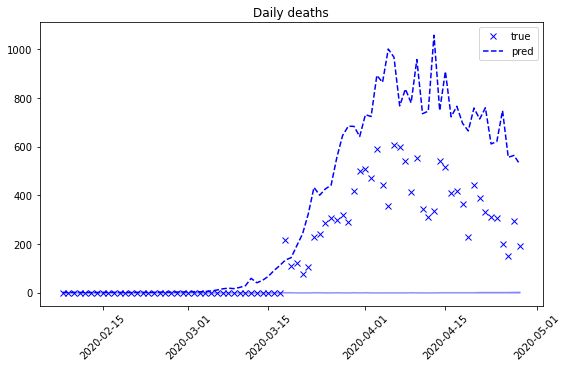

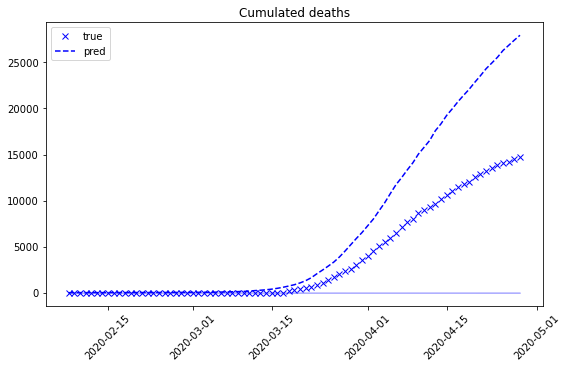

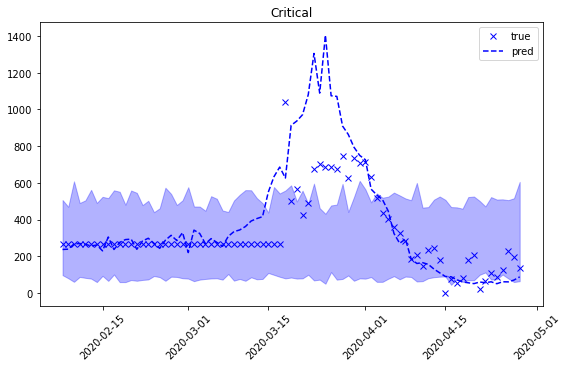

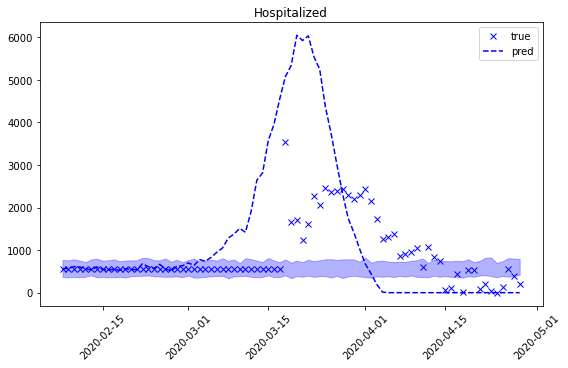

In [34]:
plot_hcd_results(mu, pi, data, daily_deaths_true, times)

## Result visualization

In [14]:
def plot_compartment_results(mu, pi, y_true, times):
    plt.plot(times, y_true, "bx", label="true")
    plt.plot(times, mu, "b--", label="pred")
    plt.fill_between(times, pi[0, :], pi[1, :], color="b", alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.title('Daily deaths')

# # Control for HCD params
def plot_hcd_results(mu, pi, data, daily_deaths, times):
    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(mu[:, -1], pi[:, :, -1], daily_deaths, times)
    plt.title('Daily deaths')

    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(np.cumsum(mu[:, -1]), pi[:, :, -1], np.cumsum(daily_deaths), times)
    plt.title('Cumulated deaths')

    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(mu[:, -2], pi[:, :, -2], data[:, -2], times)
    plt.title('Critical')

    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(mu[:, -3], pi[:, :, -3], data[:, -3], times)
    plt.title('Hospitalized')


In [15]:
def compute_mu_pi_2(model, mcmc, compartments):
    y_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0], compartments=compartments)
    pop_pred = np.stack([y_pred['hosp'], y_pred['critical'], y_pred['deceased']]).T
    mu = np.mean(pop_pred, 1)
    pi = np.percentile(pop_pred.astype(float), (10., 90.), 1)
    return mu, pi

def compute_mu_pi(model, mcmc, compartments):
    y_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0], compartments=compartments)
    pop_pred = y_pred['y']
    mu = np.mean(pop_pred, 0)
    pi = np.percentile(pop_pred.astype(float), (10., 90.), 0)
    return mu, pi

In [28]:
mu, pi = compute_mu_pi(model, mcmc, 'hcd')

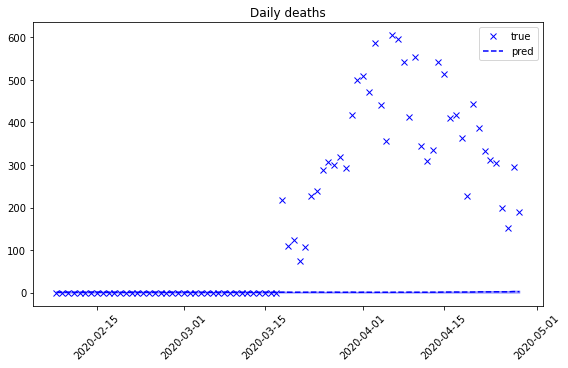

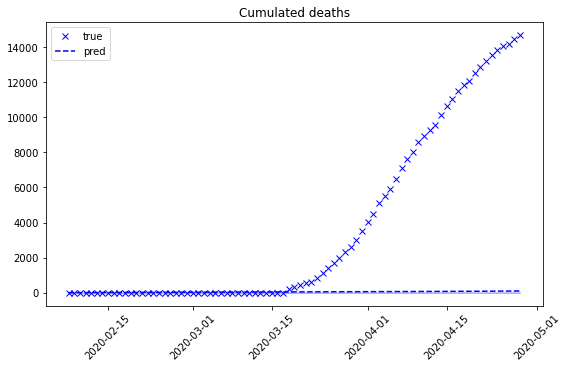

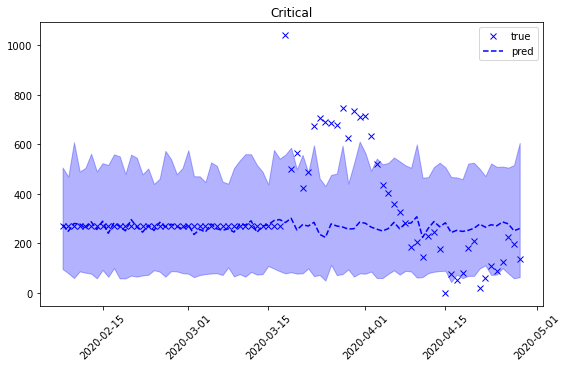

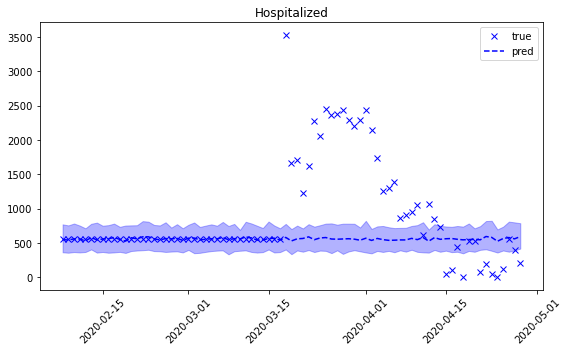

In [29]:
plot_hcd_results(mu, pi, data, daily_deaths_true, times)
plt.tight_layout()

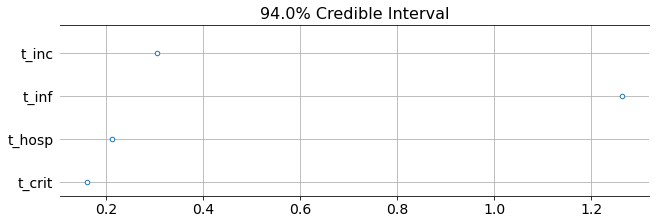

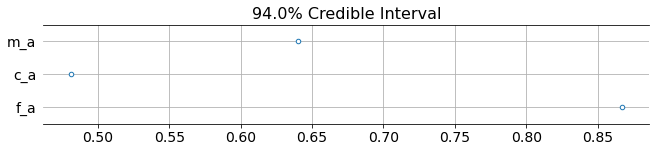

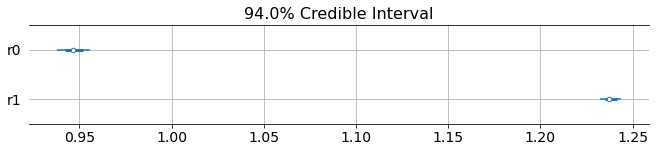

In [30]:
inference_data = az.from_numpyro(mcmc)

az.plot_forest(inference_data, var_names=['t_inc', 't_inf', 't_hosp', 't_crit'], kind='forestplot', ridgeplot_overlap=3, combined=True, figsize=(9, 3))
plt.grid()
az.plot_forest(inference_data, var_names=['m_a', 'c_a', 'f_a'], figsize=(9, 2))
plt.grid()
az.plot_forest(inference_data, var_names=['r0', 'r1'], figsize=(9, 2))
plt.grid()
# az.plot_forest(inference_data, var_names=['t_lim'], figsize=(9, 1))

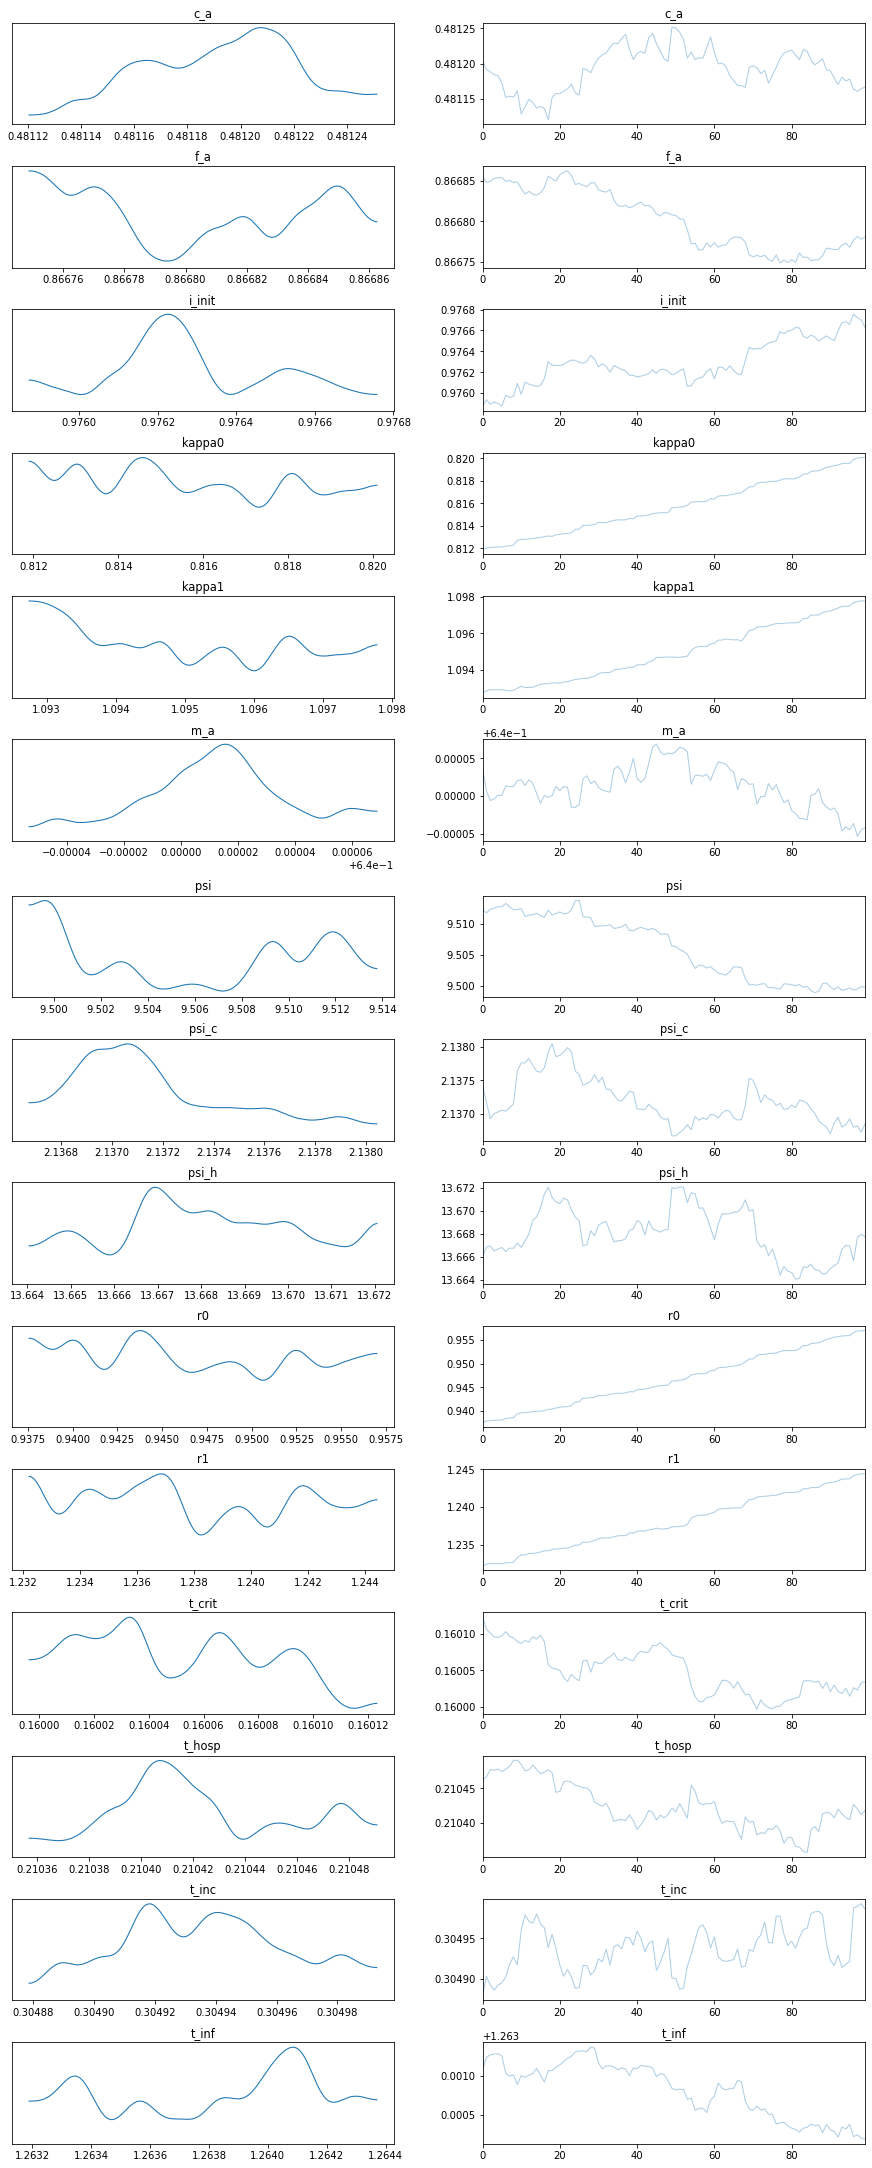

In [31]:
az.plot_trace(inference_data) ;

## Running the compartment model

In [31]:
samples = mcmc.get_samples()
# pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])

In [32]:
def run_sim_samples(mobility_data, samples):
    def dz_dt(z, t, r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a):
        s = z[0]
        e = z[1]
        i = z[2]
        r = z[3]
        h = z[4]
        c = z[5]

        int_t = np.array([t]).astype(int)[0]
        rt = r0 * (1 + mobility_data[int_t]) - r1 * mobility_data[int_t]

        ds = - (rt / t_inf) * i * s
        de = (rt / t_inf) * i * s - (e / t_inc)
        di = e / t_inc - i / t_inf
        dr = m_a * i / t_inf + (1 - c_a) * (h / t_hosp)
        dh = (1 - m_a) * (i / t_inf) + (1 - f_a) * c / t_crit - h / t_hosp
        dc = c_a * h / t_hosp - c / t_crit
        dd = f_a * c / t_crit

        return np.stack([ds, de, di, dr, dh, dc, dd])


    
    ts = np.arange(float(data.shape[0]))
    seirhcd_int_2 = build_odeint(dz_dt, rtol=1e-5, atol=1e-9, mxstep=500)
    res = []
    for i in range(samples['c_a'].shape[0]):
        post_params = dict()
        for param in 'r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a'.split(', '):
            post_params[param] = samples[param][i]
    #         post_params[param] = inference_data.posterior[param].values[0, -1]

        i_init = samples['i_init'][i]
        i_init /= pop_country
        z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
        args = post_params.values()

        sim_res = seirhcd_int_2(z_init, ts, *args)
        res.append(sim_res)

    res = np.stack(res)
    return res

In [33]:
def plot_compartment(pred_data, true_data):
    pi = np.percentile(pred_data, (10., 90.), 0)
    
    plt.plot(times, np.mean(pred_data, axis=0) * pop_country, label='pred')
    plt.plot(times, true_data, label='true')
    plt.fill_between(times, pi[0, :] * pop_country, pi[1, :] * pop_country, interpolate=True, alpha=0.3)
    plt.legend()

In [34]:
def plot_hcd(res, hosp_indexed):

    plt.subplots()
    plot_compartment(res[:, :, -3], hosp_indexed['hosp'].to_numpy())
    plt.title('hospitalized')

    plt.subplots()
    plot_compartment(res[:, :, -2], hosp_indexed['rea'].to_numpy())
    plt.title('critical')

    
    plt.subplots()
    plot_compartment(res[:, :, -1], hosp_indexed['dc'].to_numpy())
    plt.title('deaths')
    
def plot_seir(res):
    plt.subplots()
    plot_compartment(res[:, :, 0], np.zeros(res.shape[1]))
    plt.title('susceptible')

    plt.subplots()
    plot_compartment(res[:, :, 1], np.zeros(res.shape[1]))
    plt.title('exposed')

    plt.subplots()
    plot_compartment(res[:, :, 2], np.zeros(res.shape[1]))
    plt.title('infected')
    
    plt.subplots()
    plot_compartment(res[:, :, 3], np.zeros(res.shape[1]))
    plt.title('recovered')


In [35]:
mobility_data = np.asarray(mobility.to_numpy())
res = run_sim_samples(mobility_data, samples)

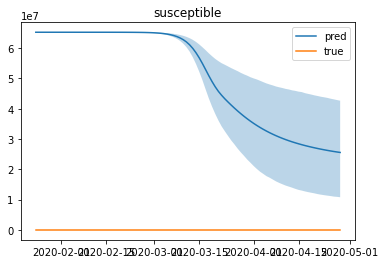

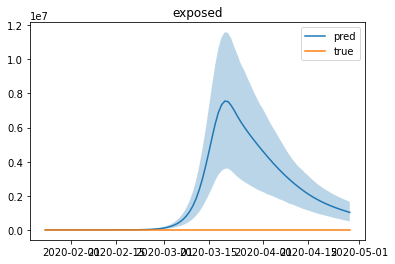

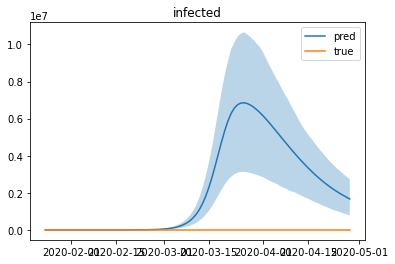

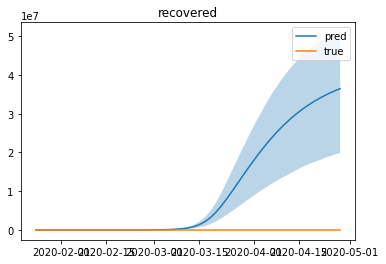

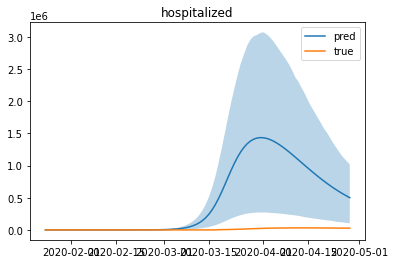

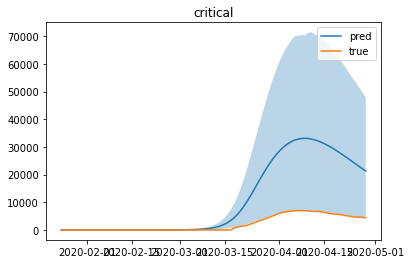

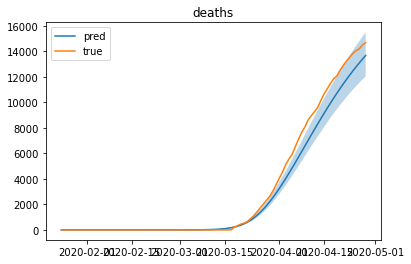

In [36]:
plot_seir(res)
plot_hcd(res, hosp_indexed)

In [37]:
mobility_fake = np.zeros(mobility_data.shape[0])
res_fake = run_sim_samples(mobility_fake, samples)

KeyboardInterrupt: 

In [ ]:
plot_seir(res_fake)
plot_hcd(res_fake, hosp_indexed)

In [108]:
def make_ode(mobility_data):
    def dz_dt(z, t, r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a):
        s = z[0]
        e = z[1]
        i = z[2]
        r = z[3]
        h = z[4]
        c = z[5]

        int_t = np.array([t]).astype(int)[0]
        rt = r0 * (1 + mobility_data[int_t]) - r1 * mobility_data[int_t]

        ds = - (rt / t_inf) * i * s
        de = (rt / t_inf) * i * s - (e / t_inc)
        di = e / t_inc - i / t_inf
        dr = m_a * i / t_inf + (1 - c_a) * (h / t_hosp)
        dh = (1 - m_a) * (i / t_inf) + (1 - f_a) * c / t_crit - h / t_hosp
        dc = c_a * h / t_hosp - c / t_crit
        dd = f_a * c / t_crit

        return np.stack([ds, de, di, dr, dh, dc, dd])
    return dz_dt


## Running SEIR-HCD model with some parameters

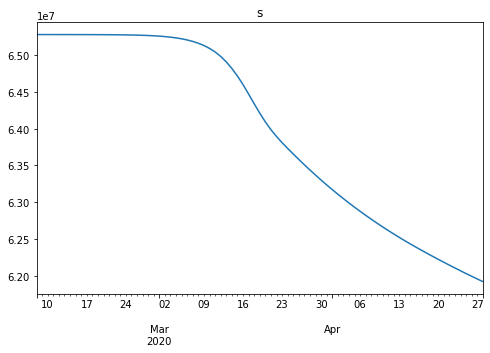

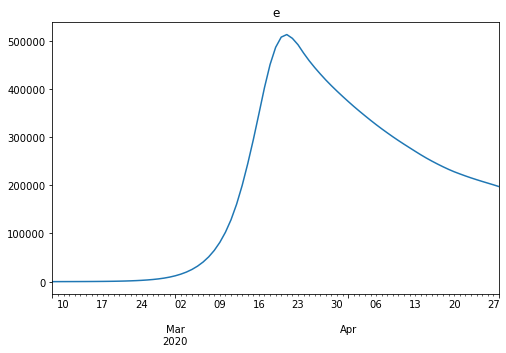

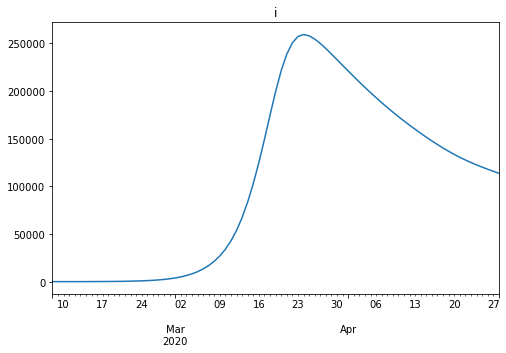

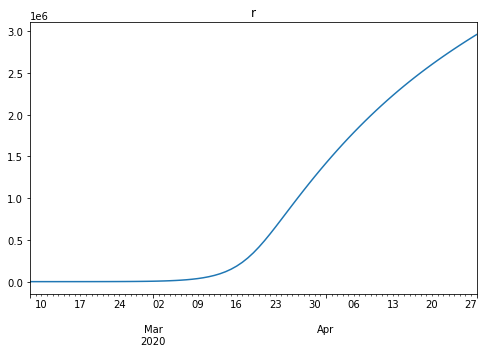

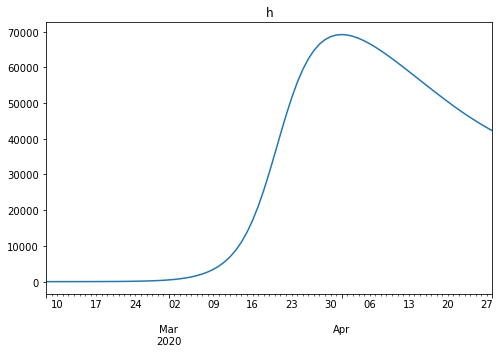

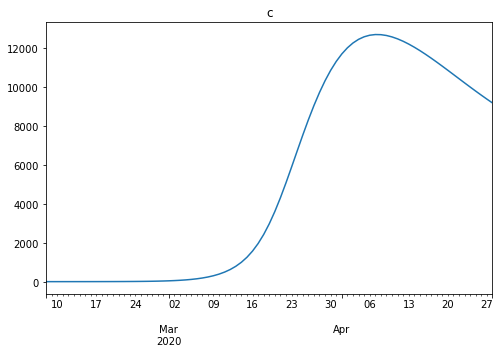

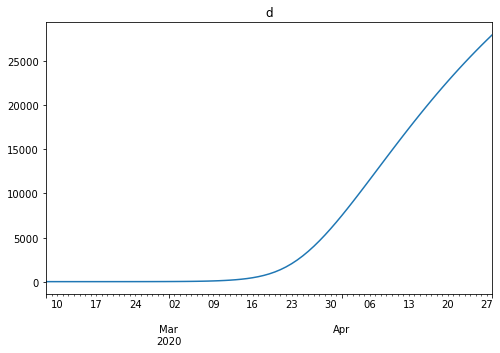

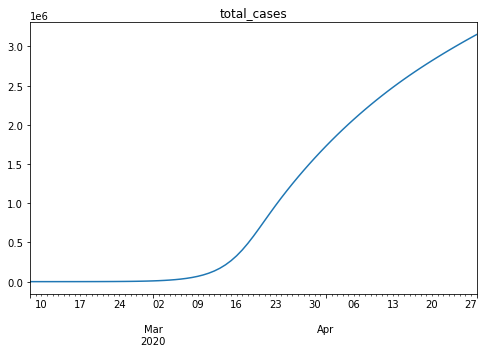

In [238]:
from collections import namedtuple

Params = namedtuple('Params', 
                    ['R0', 'R1', 
                     't_inc', 't_inf', 't_hosp', 't_crit', 
                     'm_a', 'c_a', 'f_a']
                   )

args = PRIOR_MEANS

i_init = 50
i_init /= pop_country
z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
ts = np.arange(float(data.shape[0]))

sim_res = seirhcd_int(z_init, ts, *args)

df_res = pd.DataFrame(sim_res) * pop_country
df_res.columns = 's e i r h c d'.split()

# fig, ax = plt.subplots()
df_res = df_res.eval('total_cases = i + r + h + c + d').set_index(times)
for col in df_res.columns:
    plt.subplots()
    df_res[col].plot(figsize=(8, 5))
    plt.title(col)

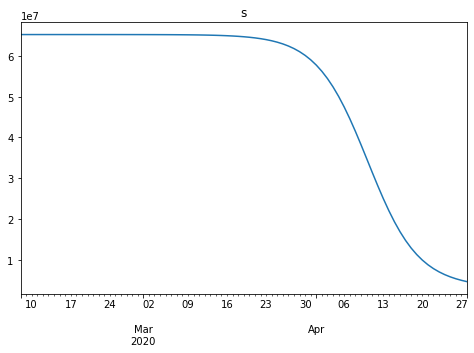

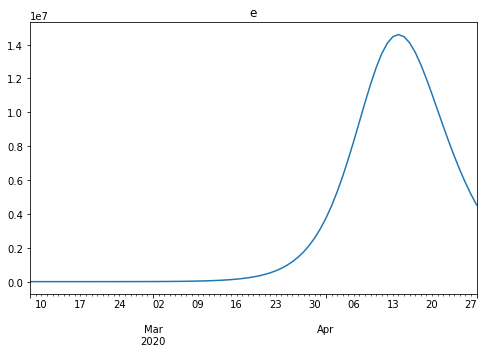

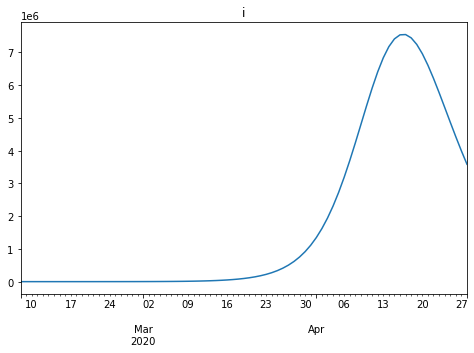

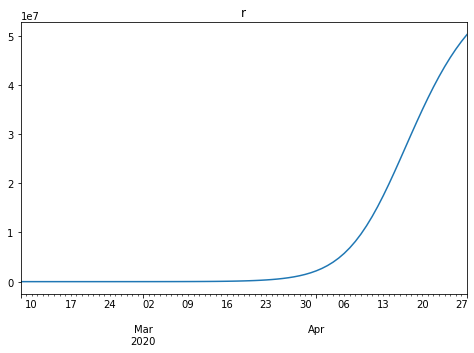

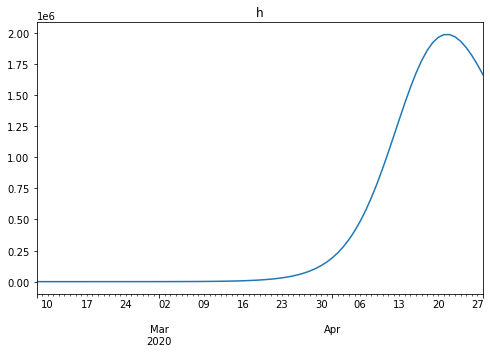

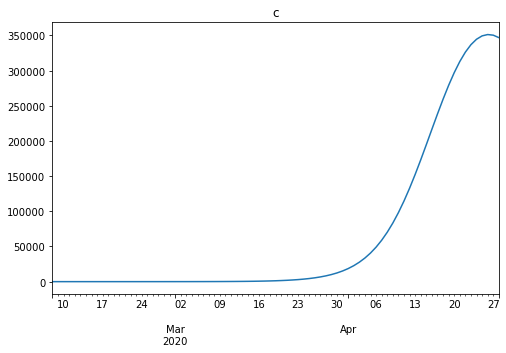

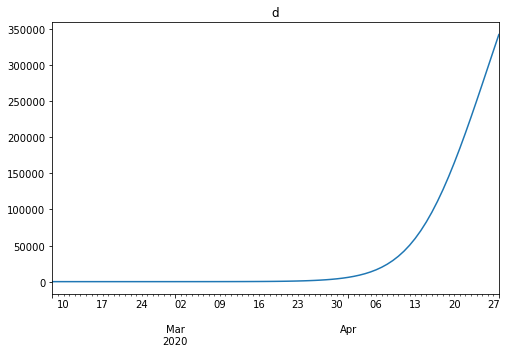

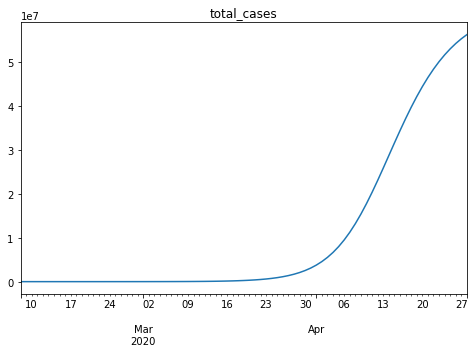

In [240]:
fake_mobility = np.zeros(data.shape[0])
seirhcd_int_fake = build_odeint(make_ode(fake_mobility), 
                                rtol=1e-5, atol=1e-9, mxstep=500)
sim_res = seirhcd_int_fake(z_init, ts, *args)

df_res = pd.DataFrame(sim_res) * pop_country
df_res.columns = 's e i r h c d'.split()

# fig, ax = plt.subplots()
df_res = df_res.eval('total_cases = i + r + h + c + d').set_index(times)
for col in df_res.columns:
    plt.subplots()
    df_res[col].plot(figsize=(8, 5))
    plt.title(col)

# Misc

(0.0, 1.0)

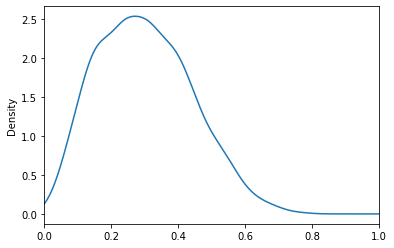

In [246]:
beta = dist.Beta(*reparametrize_beta(0.3, 10))
beta_samples = beta.sample(PRNGKey(0), (1000,))
pd.DataFrame({'samples': beta_samples}).samples.astype(float).plot.kde()
plt.xlim(0, 1)